## News Sentiment and Topic Analysis

#### Question:

How can we predict the change in crude oil price with news sentiment and topic analysis?

#### Data Source: 

1 Bloomberg News (including web news collected by Bloomberg);Topic: Crude oil; including WTI

2 WTI Crude Oil Future Trade Closing Price: Bloomberg

3 Period: 2019-08-26 to 2019-09-01, High Frequency

### Part 1: Summary Statistics of News and Price

In [41]:
import re
import pandas as pd
import numpy as np

##encoding with latin1 for special symbols
#news from bloomberg
news_bb=pd.read_csv('bb_news.csv',encoding='latin1')
##keep only subject and body
news_bb=news_bb[['Body']]
##get rid of \n and \r
news_bb['Body'] = news_bb['Body'].str.replace('\n', ' ')
news_bb['Body'] = news_bb['Body'].str.replace('\r', ' ')
##extract date and time for bloomberg news
news_bb['Date']=news_bb['Body'].str.extract(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).\d* GMT')

#news from web, web-scraping ahead
news_web=pd.read_excel('news_sample.xlsx',usecols='B,D')
news_web.columns=['Body','Date']

##concat two dataframes
frames=[news_bb,news_web]
news=pd.concat(frames)

##extract date information
news['Date'] = pd.to_datetime(news.Date) 
news['year'] = news['Date'].dt.year 
news['month'] = news['Date'].dt.month 
news['day'] = news['Date'].dt.day 
news['hour'] = news['Date'].dt.hour 
news['minute'] = news['Date'].dt.minute 
#keep only 8:26-9:01
news=news[(news['month']==8)|(news['month']==9)]
news=news[news['day']!=2]
news=news[news['day']!=3]
news.drop_duplicates(subset=['Body'],keep='first',inplace=True)
print('{}'.format(news.shape[0])+' news collected')
news.head()

259 news collected


,Body,Date,year,month,day,hour,minute
6,________________________________ Total Refi...,2019-08-26 06:12:07,2019,8,26,6,12
7,________________________________ BN 08/29 2...,2019-08-26 06:52:04,2019,8,26,6,52
8,________________________________ BN 08/29 2...,2019-08-26 07:43:39,2019,8,26,7,43
9,________________________________ BN 08/29 2...,2019-08-26 09:24:06,2019,8,26,9,24
10,________________________________ ASIA CRUDE...,2019-08-26 09:57:25,2019,8,26,9,57


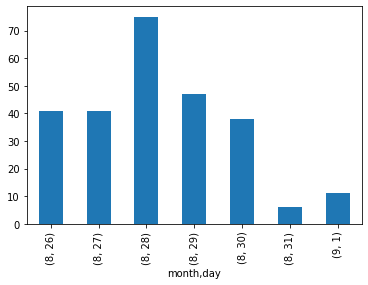

In [24]:
##plot the frequency of news by day and hour
news.groupby(['month','day']).count()['Body'].plot(kind='bar')

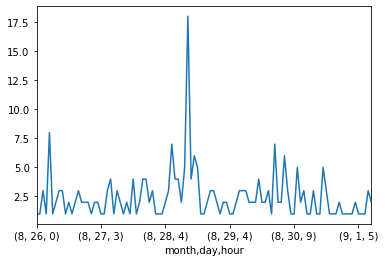

In [25]:
### plot the frequency of news by day
news.groupby(['month','day','hour']).count()['Body'].plot()

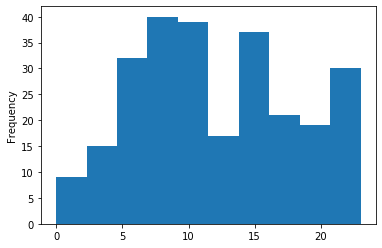

In [27]:
#check news frequency throughout a day
news['Date'].map(lambda d: d.hour).plot(kind='hist')

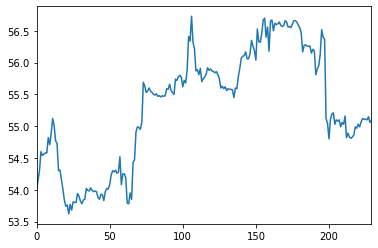

In [67]:
%matplotlib inline
price=pd.read_excel('price.xlsx',sheet_name='Sheet3')
price['Close'].plot()

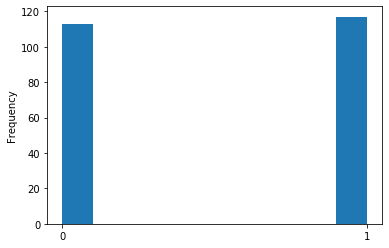

In [71]:
price_diff=price.diff()
price_diff['price']=np.where(price_diff.Close>=0,1,0)
price_final=price.merge(price_diff,left_index=True,right_index=True,how='inner')
###dataframe used to store the information
price_final=pd.read_excel('price_final.xlsx')
price_final['price'].plot(kind='hist',xticks=[0,1])

In [15]:
#merged news and price into a same dataframe
final=pd.read_excel('final.xlsx')
final.head()

,Dates,price,Date,body
0,2019-08-26 00:30:00,1,2019-08-26 00:03:08,jakarta price west texa intermedi wit crude oi...
1,2019-08-26 04:30:00,0,2019-08-26 04:16:04,var ssd ssd ssd editorialmetadata countri regi...
2,2019-08-26 06:30:00,0,2019-08-26 06:12:07,total refineri ali trade woe european energi f...
3,2019-08-26 06:30:00,0,2019-08-26 06:28:40,invest com - oil price monday asia china annou...
4,2019-08-26 06:30:00,0,2019-08-26 06:05:25,oil price fell end last week china unveil reta...


### Part 2: Preprocessing News

In [68]:
import nltk
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker   
from sklearn.feature_extraction.text import CountVectorizer

spell = SpellChecker() 
porter_stemmer = PorterStemmer()

###stopwords
with open('StopWords_GenericLong.txt', 'r') as f:
    x_gl = f.readlines()
with open('StopWords_Names.txt', 'r') as f:
    x_n = f.readlines()
with open('StopWords_DatesandNumbers.txt', 'r') as f:
    x_d = f.readlines()
with open('StopWords_Geographic.txt', 'r') as f:
    x_g = f.readlines()
stopwords = nltk.corpus.stopwords.words('english')
[stopwords.append(x) for x in x_gl]
[stopwords.append(x) for x in x_n]
[stopwords.append(x) for x in x_d]
[stopwords.append(x) for x in x_g]

##define function for spell check, tokenize, stopwords, stem
def stemming_tokenizer(str_input):
    ##lower case, word tokenize,get rid of unnecessary symbols
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    ##merge hyphenated word by the new line
    words= [re.sub(r'-\n','', word) for word in words]
    ##spell check
    words = [spell.correction(word) for word in words]
    ###get rid of stopword
    words = [word for word in words if word not in stopwords]
    ##stemming
    words = [porter_stemmer.stem(word) for word in words]
    return words


#news['body_token']=news['Body'].apply(stemming_tokenizer)
#news['body'] = news['body_token'].apply(lambda x: ','.join(map(str, x)))
#news['body']=news['body'].str.replace(',', ' ')
#news.to_excel('news_body.xlsx',index=None)
news_body=pd.read_excel('news_body.xlsx')
news_body['body'][1]

'bn 08 29 21 03 oil climb two-week high u china trade talk hope bn 08 28 21 24 oil ralli peter demand concern counter inventori draw bn 08 27 21 43 oil rise industri data show u crude inventori draw bn 08 26 20 36 oil weaken uncertainti u china trade talk hit oil longest lose run five week trade war deepen 2019-08-26 06 52 04 61 gmt sharon cho bloomberg i- oil fell fourth day set longest run declin five week latest escal trade war blindsid investor worsen already-shaki global demand outlook futur new york drop much 2 2 close 2 1 friday beij said would impos retaliatori tariff anoth 75 billion u good includ oil first time presid donald trump later respond addit tariff increas chines good also call american compani pull asia largest economi deepen trade hostil wrong-foot hedg fund slash bearish bet crude week aug 20 oil ralli 10 low earli august relat u china appear improv start fall last wednesday global trade system total anarchi said howi lee economist oversea-chines bank corp end blo

### Part 3: News Sentiment Analysis

In [17]:
df=pd.read_excel('final.xlsx')

###get rid of all numbers
df['body']= df['body'].str.replace(r'\d', '')

###split train and test
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['body'], 
                                                    df['price'], 
                                                    random_state=0)

#### Bag of Words

In [47]:
###bag of words
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=2,max_df=0.1).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Number of Features: {}'.format(len(vect.get_feature_names())))

Number of Features: 2680


In [33]:
###use logistic regression model to train 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.6539961013645225


In [34]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['yuan' 'rig' 'polit' 'nigeria' 'wingfield' 'pump' 'brian' 'outweigh'
 'est' 'build']
Largest Coefs: 
['yesterday' 'treasuri' 'thu' 'respond' 'herron' 'rebound' 'canadian'
 'christoph' 'edg' 'resolv']


#### Bag of Words with ngrams

In [60]:
vect = CountVectorizer(min_df=5,max_df=0.1,ngram_range=(1,3)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
#adding bigrams can increase the number of features by a lot
print('Number of Features: {}'.format(len(vect.get_feature_names())))
      
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Number of Features: 3001
AUC:  0.6647173489278753
Smallest Coefs:
['yuan' 'support level' 'est' 'rig' 'oil ga' 'ab' 'job' 'spend' 'pump'
 'brian']
Largest Coefs: 
['oh' 'thu' 'yesterday' 'us per' 'us per barrel' 'resolv' 'treasuri'
 'trade session' 'plant' 'wit oil']


#### TFIDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=5,max_df=0.1).fit(X_train)
print('Number of Features: {}'.format(len(vect.get_feature_names())))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

###find out the words that contributes to price increase or decrease
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
print('Smallest Coefs:\n{}'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Number of Features: 1120
AUC:  0.5531189083820662
Smallest Coefs:
['rig' 'yuan' 'earn' 'summer' 'etc' 'hedg' 'free' 'front' 'et'
 'manufactur']
Largest Coefs: 
['canadian' 'yesterday' 'rohan' 'cer' 'neb' 'herron' 'regul' 'forex'
 'process' 'snapshot']


### Part 4: Future Work--News Topic Analysis

In [56]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the list of documents
docs=df['body']
# remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
vect = TfidfVectorizer(min_df=20, max_df=0.2)
#fit and transform documents to tfidf vectorizer
X = vect.fit_transform(docs)

# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())

# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10,id2word=id_map,passes=25,random_state=34)

def lda_topics():
    
    # Your Code Here
    lis=ldamodel.show_topics(num_topics=10,num_words=10)
    
    return lis 
lda_topics()

[(0,
  '0.075*"canadian" + 0.041*"pipelin" + 0.039*"canada" + 0.021*"cush" + 0.021*"refineri" + 0.020*"regul" + 0.015*"risk" + 0.014*"mid" + 0.013*"sourc" + 0.011*"spot"'),
 (1,
  '0.060*"percent" + 0.046*"index" + 0.046*"et" + 0.024*"free" + 0.018*"point" + 0.014*"account" + 0.012*"creat" + 0.007*"yield" + 0.007*"schedul" + 0.006*"broker"'),
 (2,
  '0.015*"public" + 0.014*"dubai" + 0.013*"meanwhil" + 0.013*"lost" + 0.002*"bbl" + 0.002*"front" + 0.002*"agreement" + 0.002*"yesterday" + 0.002*"place" + 0.002*"believ"'),
 (3,
  '0.007*"dollar" + 0.007*"bpd" + 0.007*"ga" + 0.006*"good" + 0.006*"percent" + 0.006*"posit" + 0.006*"read" + 0.006*"billion" + 0.005*"index" + 0.005*"rate"'),
 (4,
  '0.040*"bbl" + 0.031*"marino" + 0.020*"content" + 0.018*"david" + 0.018*"half" + 0.016*"mm" + 0.016*"summer" + 0.014*"survey" + 0.012*"bullish" + 0.010*"et"'),
 (5,
  '0.012*"money" + 0.011*"tabl" + 0.011*"washington" + 0.010*"manag" + 0.010*"posit" + 0.007*"select" + 0.007*"gold" + 0.007*"natur" + 0.0